In [86]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [87]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [88]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [89]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [90]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [91]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [92]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [93]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [94]:
# Create an inspector object
from sqlalchemy import inspect
inspector = inspect(engine)

In [95]:
#station columns
columns_station = [col['name'] for col in inspector.get_columns('station')]
columns_station

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [96]:
#measurement columns
columns_measurement = [col['name'] for col in inspector.get_columns('measurement')]
columns_measurement

['id', 'station', 'date', 'prcp', 'tobs']

In [97]:
# Find the most recent date in the data set.
from sqlalchemy import desc  # Import desc for descending order
measurement_most_recent_date = session.query(measurement).order_by(desc(measurement.date)).first().date
measurement_most_recent_date

'2017-08-23'

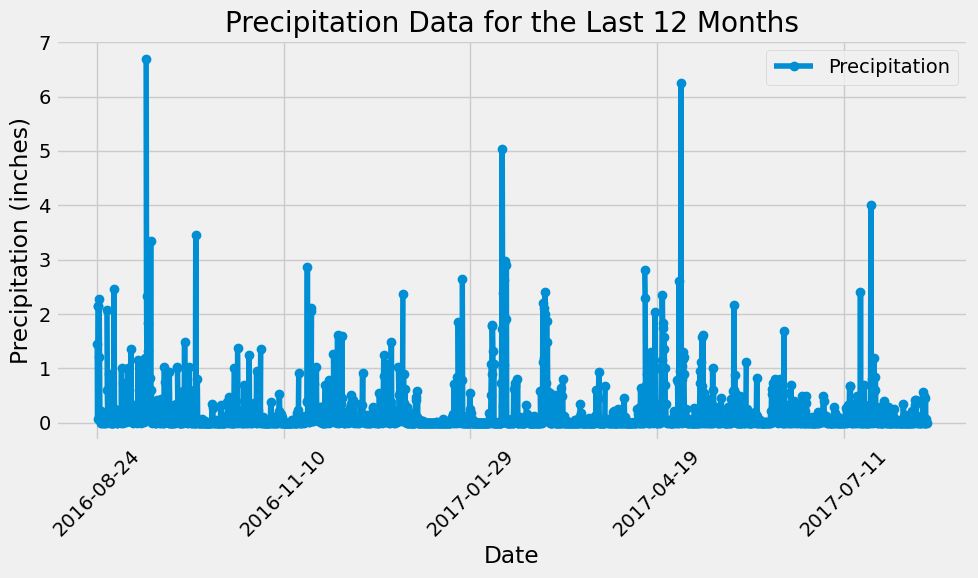

In [98]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
twelve_months_ago = datetime.strptime(measurement_most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data_12mo = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= twelve_months_ago)\
    .order_by(desc(measurement.date))\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data_12mo, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', ascending=True, inplace=True)
precipitation_df.reset_index(drop=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', kind='line', figsize=(10, 6), marker='o')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.grid(True) 
plt.tight_layout()
plt.show()

In [99]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['Precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [100]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).distinct().count()
total_stations

9

In [101]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(station.station,
                                func.count(measurement.id)).filter(
                                    station.station == measurement.station
                                ).group_by(station.station).order_by(
                                    func.count(measurement.id).desc()).all()
for station_name, count in active_stations:
    print(f"Station: {station_name}: Measurement Row Count = {count}")

Station: USC00519281: Measurement Row Count = 2772
Station: USC00519397: Measurement Row Count = 2724
Station: USC00513117: Measurement Row Count = 2709
Station: USC00519523: Measurement Row Count = 2669
Station: USC00516128: Measurement Row Count = 2612
Station: USC00514830: Measurement Row Count = 2202
Station: USC00511918: Measurement Row Count = 1979
Station: USC00517948: Measurement Row Count = 1372
Station: USC00518838: Measurement Row Count = 511


In [102]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_name = active_stations[0].station
most_active_station_name

temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_name)

#list unpack
temp_min, temp_max, temp_avg = temperature_stats[0]

print(f"Most Active Station: {most_active_station_name}")
print(f"Lowest Temperature: {temp_min}")
print(f"Highest Temperature: {temp_max}")
print(f"Average Temperature: {round(temp_avg,2)}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


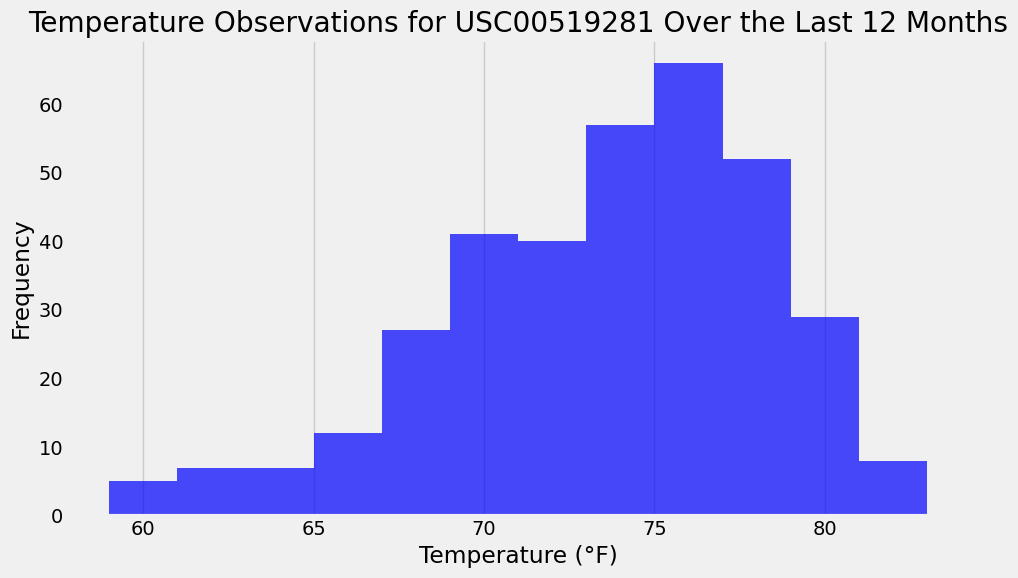

In [105]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data_12mo = session.query(measurement.date, measurement.tobs)\
    .filter(measurement.date >= twelve_months_ago)\
    .filter(measurement.station == most_active_station_name)\
    .order_by(desc(measurement.date))\
    .all()
temp_data_12mo

temp_df = pd.DataFrame(temp_data_12mo, columns=['Date', 'Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temp_df['Temperature'], bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for {most_active_station_name} Over the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Close Session

In [104]:
# Close Session
session.close()